# Import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Utils

In [2]:
def calculate_metrics(TN, FP, FN, TP, f_beta=1):
    Acc = (TP+TN)/(TN+FP+FN+TP)
    P = TP/(TP+FP)
    R = TP/(TP+FN)
    F = (1+pow(f_beta,2))*(P*R)/((pow(f_beta,2))*P+R)
    TNR = TN/(TN+FN)
    return Acc, P, R, F, TNR

# Define variables

In [3]:
model_names = ["Vilt", "Blip_large", "GiT_base", "GiT_large"] # skip , "Blip_base"
model_type = "VQA"
D_type = "1"

full_df_columns = ["model_name", "P_type", "thr", "TP", "TN", "FP", "FN", "Acc", "P", "R", "F", "TNR"]

numeric_cols = ["used_language", "specificity", "question_length", "complexity", "image_relatedness", "image_difficulty", "difficulty", \
                "no_tokens", "correct", "N", "Prob", "P_T_1", 'P_T_2_N']

Probs = ["Prob", "P_T_1", "P_T_2_N"]
Porbs_colors = {"Prob":"red", "P_T_1":"green", "P_T_2_N":"blue"}

Plot_names = ["Acc", "F", "P", "TNR"]

numeric_cols_dtype = dict()
for c in numeric_cols: numeric_cols_dtype[c]=float
numeric_cols_dtype

{'used_language': float,
 'specificity': float,
 'question_length': float,
 'complexity': float,
 'image_relatedness': float,
 'image_difficulty': float,
 'difficulty': float,
 'no_tokens': float,
 'correct': float,
 'N': float,
 'Prob': float,
 'P_T_1': float,
 'P_T_2_N': float}

# Read full results df

In [4]:
full_results_df = pd.read_excel(f"./{model_type}_full_results_D_type_{D_type}_manual.xlsx", sheet_name=f"{model_type}_D_type_{D_type}_results",
                                dtype=numeric_cols_dtype)

full_results_df.head()

,ID,image_name,example_question,question,answer_gt,used_language,specificity,question_length,complexity,image_relatedness,...,P_T_2_N,x_max_str,x_min_str,Prob_str,T_1_max_str,T_1_str,P_T_1_str,T_2_max_N_str,T_2_N_str,P_T_2_N_str
0,0,Gaussian_5_2,what is in the image?,what is in the image?,random+noise+nothing+t know+not sure+unknown+c...,0.0,1.0,0.0,0.0,0.0,...,0.035396,-2.3610375,-16.713715,0.07764137,1.7832804974941396,1.3263668739558916,0.033901606,1.738079,1.307533,0.035396315
1,1,Gaussian_5_2,what is the dominant color of the image?,what is the dominant color of the image?,color+gray+grey+nothing+t know+not sure+unknow...,0.0,1.0,0.0,0.0,0.0,...,0.166710,-0.49326575,-27.210875,0.20900321,3.319589136322892,1.9664954734678717,0.08871711,1.738079,1.307533,0.16670989
2,2,Gaussian_5_2,what does the image represent?,what does the image represent?,random+noise+nothing+t know+not sure+unknown+c...,0.0,1.0,0.0,0.0,0.0,...,0.039332,-2.180196,-17.993324,0.08220834,1.964737514053651,1.4019739641890212,0.031976696,1.738079,1.307533,0.03933237
3,3,Gaussian_5_2,why is the image random?,why is the image random?,random+t know+not sure+unknown+can't tell+none...,0.0,1.0,0.0,0.0,0.0,...,0.051415,-2.5192337,-19.845095,0.12248334,2.152690347564782,1.4802876448186593,0.034029774,1.738079,1.307533,0.05141516
4,4,Gaussian_5_2,why aren't there any objects in the image?,why aren't there any objects in the image?,random+noise+t know+not sure+unknown+can't tel...,0.0,1.0,0.0,0.0,0.0,...,0.029139,-3.1362438,-18.810205,0.06400901,1.9474464197595112,1.394769341566463,0.024084808,1.738079,1.307533,0.02913933


# Add valid column

In [5]:
not_nan = np.array(~(full_results_df['clean_answer']).isna())
not_qst_mark = np.array(~(full_results_df['clean_answer'].str.contains('?', na=True, regex=False)))

valid = np.where(not_nan, 1, 0)

data = full_results_df.copy()
data["valid"] = valid

len(data)

14276

In [6]:
data["no_tokens"] = data["no_tokens"]/np.max(list(data["no_tokens"]))

# Thresholds analysis

In [7]:
thrs = [i/100 for i in range(20, 81, 2)]
len(thrs)

31

In [8]:
all_rows = list()
for model_name in model_names+["all"]:
    model_df = data.loc[(data["valid"]==1)]
    if "all"!=model_name: model_df=model_df.loc[(model_df["model_name"]==model_name)]
    model_correct = np.array(model_df["correct"]).astype(np.int32)
    for Prob in Probs:
        model_P = np.array(model_df[Prob])
        for thr in thrs:
            model_P_correct = np.where(model_P>=thr, 1, 0)
            TN, FP, FN, TP = confusion_matrix(model_correct, model_P_correct).ravel()
            Acc, P, R, F, TNR = calculate_metrics(TN, FP, FN, TP, f_beta=0.5)
            one_row = [model_name, Prob, thr, TP, TN, FP, FN, Acc, P, R, F, TNR]
            all_rows.append(one_row)       
        

In [9]:
len(all_rows)

465

In [10]:
full_df_columns

['model_name',
 'P_type',
 'thr',
 'TP',
 'TN',
 'FP',
 'FN',
 'Acc',
 'P',
 'R',
 'F',
 'TNR']

In [11]:
T_df = pd.DataFrame(np.array(all_rows), columns=full_df_columns)
T_df.head()

,model_name,P_type,thr,TP,TN,FP,FN,Acc,P,R,F,TNR
0,Vilt,Prob,0.2,595,1331,1475,168,0.5396469599327542,0.28743961352657005,0.7798165137614679,0.32898374433263294,0.8879252835223482
1,Vilt,Prob,0.22,560,1436,1370,203,0.5592602970019613,0.29015544041450775,0.7339449541284404,0.33007190852292817,0.87614399023795
2,Vilt,Prob,0.24,531,1536,1270,232,0.5791538246007285,0.29483620210993894,0.6959370904325033,0.3332496548261579,0.8687782805429864
3,Vilt,Prob,0.26,506,1616,1190,257,0.594564303726534,0.2983490566037736,0.6631716906946264,0.3352325427322114,0.8627869727709557
4,Vilt,Prob,0.28,480,1704,1102,283,0.6119361165592603,0.3034134007585335,0.6290956749672346,0.3384571992666761,0.8575742325113236


In [12]:
T_df_numeric_cols = full_df_columns[2:]
T_df[T_df_numeric_cols] = T_df[T_df_numeric_cols].apply(pd.to_numeric)

In [13]:
# with pd.ExcelWriter(f"./{model_type}_T_analysis_manual.xlsx", engine="openpyxl", mode="w") as writer:
#     T_df.to_excel(writer, sheet_name=f"{model_type}_T_analysis", index_label='ID')

# Plots

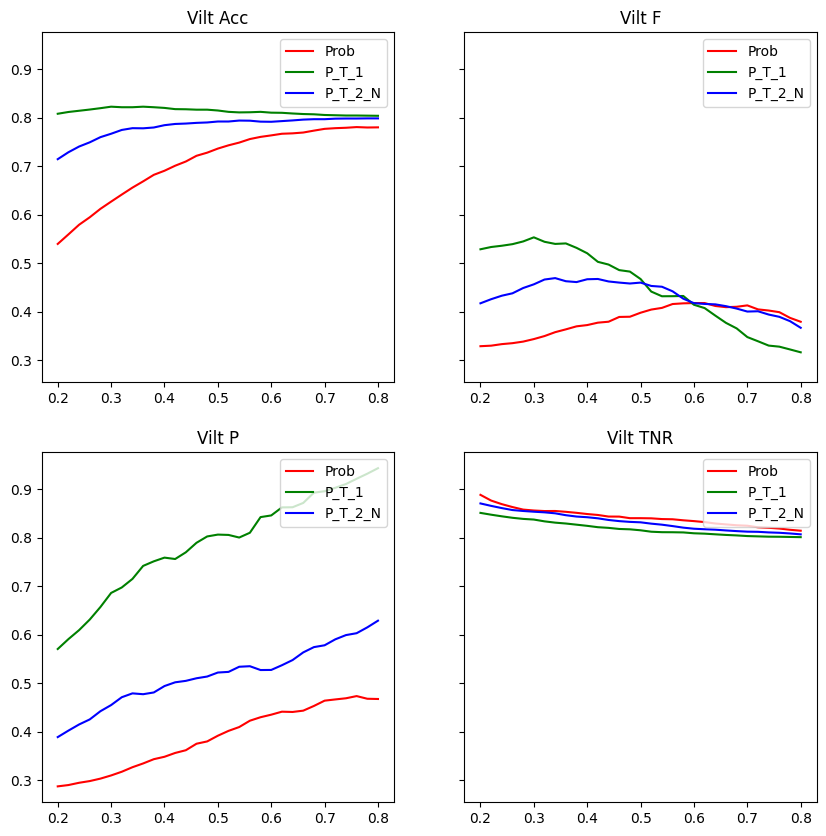

In [14]:
model_name = "Vilt"
model_df = T_df.loc[T_df["model_name"]==model_name]

nrows, ncols = 2, 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=(10,10))


plot_idx = 0
for row_idx in range(nrows):
    for col_idx in range(ncols):
        Plot_name = Plot_names[plot_idx]
        plot_idx += 1
        for Prob in Probs:
            curve = list(model_df.loc[model_df["P_type"]==Prob][Plot_name])
            ax[row_idx, col_idx].plot(thrs, curve, color=Porbs_colors[Prob], label=Prob)
        ax[row_idx, col_idx].set_title(f"{model_name} {Plot_name}")
        ax[row_idx, col_idx].legend(loc="upper right")


In [15]:
# Green 0.3
# Blue 0.44~0.46
# Red 0.48~0.5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


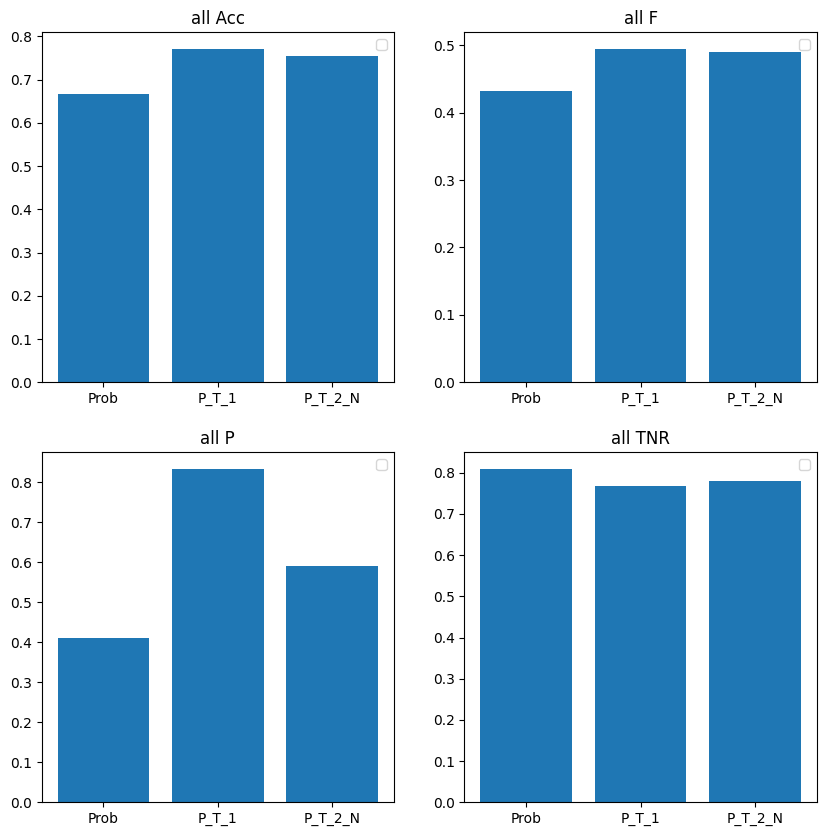

In [16]:
model_name = "all"
model_df = T_df.loc[T_df["model_name"]==model_name]

thrs_list = [0.3, 0.44, 0.48]

nrows, ncols = 2, 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))


plot_idx = 0
for row_idx in range(nrows):
    for col_idx in range(ncols):
        Plot_name = Plot_names[plot_idx]
        plot_idx += 1
        values = list()
        for idx in range(len(Probs)):
            v = model_df.loc[(model_df["thr"]==thrs_list[idx]) & (model_df["P_type"]==Probs[idx])][Plot_name].values[0]
            values.append(v)

        ax[row_idx, col_idx].bar(Probs, values)

        ax[row_idx, col_idx].set_title(f"{model_name} {Plot_name}")
        ax[row_idx, col_idx].legend(loc="upper right")

# AUC and ROC threshold

In [17]:
df = pd.read_excel(f"./{model_type}_T_analysis_manual.xlsx", sheet_name=f"{model_type}_T_analysis",
                    dtype=numeric_cols_dtype)

df.head()

,ID,model_name,P_type,thr,TP,TN,FP,FN,Acc,P,R,F,TNR
0,0,Vilt,Prob,0.20,595,1331,1475,168,0.539647,0.287440,0.779817,0.328984,0.887925
1,1,Vilt,Prob,0.22,560,1436,1370,203,0.559260,0.290155,0.733945,0.330072,0.876144
2,2,Vilt,Prob,0.24,531,1536,1270,232,0.579154,0.294836,0.695937,0.333250,0.868778
3,3,Vilt,Prob,0.26,506,1616,1190,257,0.594564,0.298349,0.663172,0.335233,0.862787
4,4,Vilt,Prob,0.28,480,1704,1102,283,0.611936,0.303413,0.629096,0.338457,0.857574


In [18]:
all_rows = list()
for model_name in model_names+["all"]:
    # print(model_name)
    model_df = data.loc[(data["valid"]==1)]
    if model_name!="all": model_df=model_df.loc[(model_df["model_name"]==model_name)]
    correct_col = np.array(model_df["correct"]).astype(np.int32)
    for P_type in Probs:
        P_col = np.array(model_df[P_type]).astype(np.float64)
        roc_auc = roc_auc_score(correct_col, P_col)
        # print(f"{P}\t{roc_auc}")
        
        FP_rate, TP_rate, P_thrs = roc_curve(correct_col, P_col)
        P_thrs_optimal = sorted(list(zip(np.abs(TP_rate - FP_rate), P_thrs)), key=lambda i: i[0], reverse=True)[0][1] # Youden's index
        # print(f"{P}\t{P_thrs_median}")
        model_P_correct = np.where(P_col>=P_thrs_optimal,1,0)
        TN, FP, FN, TP = confusion_matrix(correct_col, model_P_correct).ravel()
        Acc, P, R, F, TNR = calculate_metrics(TN, FP, FN, TP, f_beta=0.5)
        # "model_name", "P_type", "optimal_thr", "TP", "TN", "FP", "FN", "Acc", "P", "R", "F", "TNR", "roc_auc"
        row = [model_name, P_type, P_thrs_optimal, TP, TN, FP, FN, Acc, P, R, F, TNR, roc_auc]
        all_rows.append(row)


In [19]:
auc_df_num_cols = ["optimal_thr", "TP", "TN", "FP", "FN", "Acc", "P", "R", "F", "TNR", "roc_auc"]
auc_df_cols = ["model_name", "P_type"] + auc_df_num_cols

In [20]:
# numeric_cols_dtype = dict()
# for c in auc_df_num_cols: numeric_cols_dtype[c]=float
# numeric_cols_dtype

In [21]:
auc_df = pd.DataFrame(all_rows, columns=auc_df_cols)
auc_df[auc_df_num_cols] = auc_df[auc_df_num_cols].apply(pd.to_numeric)

In [22]:
# with pd.ExcelWriter(f"./{model_type}_T_AUC_ROC_manual.xlsx", engine="openpyxl", mode="w") as writer:
#     auc_df.to_excel(writer, sheet_name=f"{model_type}_T_AUC_ROC", index_label='ID')